# Leaf-Disease-Detection

## Importing Libraries

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt

## Defing Hyperparameters

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 15

## Importing Image Data

In [3]:
dataset = tf.keras.utils.image_dataset_from_directory(
    "../Dataset", 
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [4]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
# number of batches(per batch 32)
len(dataset)

501

## Realizing The Data

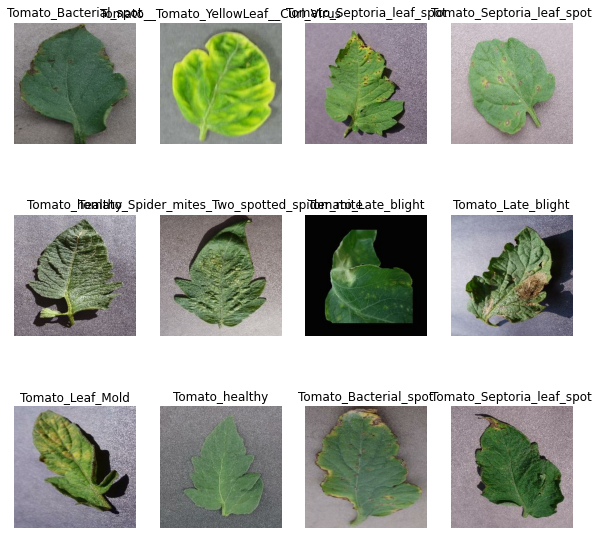

In [6]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

## Train Test Validation Spliting

In [7]:
# // 80% ==> training
# // 20% ==> 10% validation, 10% test

In [8]:
train_size = 0.8
len(dataset)*train_size 

400.8

In [9]:
def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    if(shuffle):
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_ds = dataset.take(train_size)
    test_ds  = dataset.skip(train_size)
    val_ds   = test_ds.take(val_size)
    test_ds  = test_ds.skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [11]:
print(len(train_ds),len(val_ds),len(test_ds))

400 50 51


## Data Preprocessing

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [14]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

# Building The Model

In [15]:
input_shape = [BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS]
n_classes = len(dataset.class_names)

In [16]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])

model.build(input_shape = input_shape)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [18]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

## Model Training 

In [19]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data = val_ds,
    verbose=1,
    epochs = EPOCHS,
)

Epoch 1/15
400/400 [==============================] - 1052s 3s/step - loss: 1.5806 - accuracy: 0.4431 - val_loss: 1.5278 - val_accuracy: 0.4981
Epoch 2/15
400/400 [==============================] - 981s 2s/step - loss: 0.8829 - accuracy: 0.6908 - val_loss: 2.1268 - val_accuracy: 0.5144
Epoch 3/15
400/400 [==============================] - 974s 2s/step - loss: 0.6444 - accuracy: 0.7742 - val_loss: 1.3431 - val_accuracy: 0.6162
Epoch 4/15
400/400 [==============================] - 1118s 3s/step - loss: 0.5445 - accuracy: 0.8075 - val_loss: 1.0542 - val_accuracy: 0.6719
Epoch 5/15
400/400 [==============================] - 645s 2s/step - loss: 0.4778 - accuracy: 0.8283 - val_loss: 1.2598 - val_accuracy: 0.6756
Epoch 6/15
400/400 [==============================] - 734s 2s/step - loss: 0.4300 - accuracy: 0.8455 - val_loss: 1.2137 - val_accuracy: 0.6881
Epoch 7/15
400/400 [==============================] - 659s 2s/step - loss: 0.3883 - accuracy: 0.8590 - val_loss: 0.7495 - val_accuracy: 0.77

In [20]:
# model = tf.keras.models.load_model("../Saved_Models/1")
scores = model.evaluate(test_ds)

51/51 [==============================] - 51s 635ms/step - loss: 0.2747 - accuracy: 0.9025


## Measuring Performance

In [21]:
print(history)
print(history.params)
print(history.history.keys())

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

{'verbose': 1, 'epochs': 15, 'steps': 400}
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


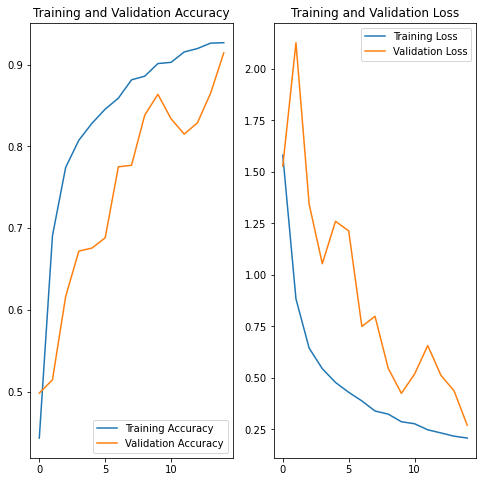

In [22]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

the image is :  Tomato_Late_blight
the pridiction is :  Tomato_Late_blight


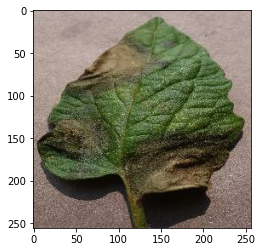

In [23]:
for image_batch, label_batch in test_ds.take(1):
    
    first_image = image_batch[0].numpy().astype('uint8')
    first_lable = label_batch[0].numpy()
    
    plt.imshow(first_image)
    print("the image is : ",class_names[first_lable])
    batch_prediction = model.predict(image_batch)
    
    print("the pridiction is : ",class_names[np.argmax(batch_prediction[0])])
    

In [24]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

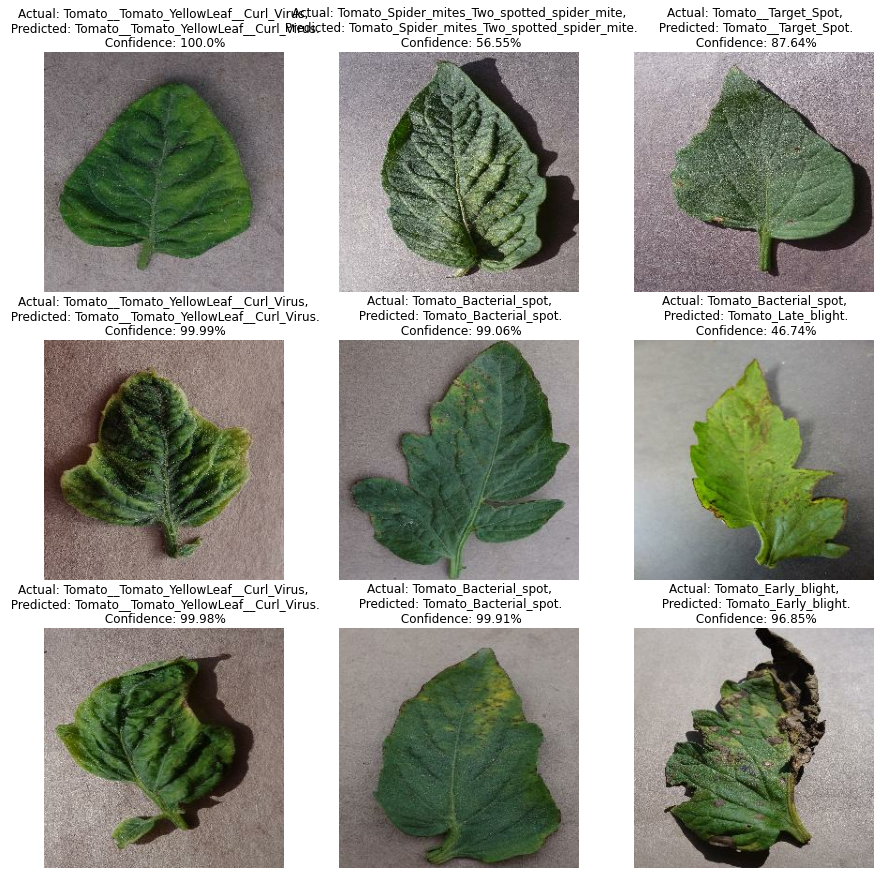

In [25]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

## Saving The Model

In [26]:
import os
model_version = max([int(i) for i in os.listdir("../Saved_Models") + [0]])+1
model.save(f"../Saved_Models/{model_version}")

INFO:tensorflow:Assets written to: ../Saved_Models/2\assets


In [27]:
model.save("../nameit_c.h5")